# CMDA 4634 - Image Filters with GPU using Numba

## By: Pranav Kannan



In [1]:
# Use this line to check/install numba
# !pip install numba

In [2]:
# Use this to check if you have access to a GPU
# !nvidia-smi

# Use this line to check if the CUDA Toolkit version is compatible
# !nvcc --version

In [3]:
# Import statements
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from numba import jit, njit, cuda, types as numba_types

In [4]:
# Setting the file name
# fileName = "iron_man.png"
fileName = "sky.png"

## Creating a CPU Kernel

Our first goal is to get a benchmark of the grayscale operation running in serial on the CPU

In [5]:
# Defining the CPU kernel
def convertToGrayscaleCPU(F):
    for i in range(len(F)):
        for j in range(len(F[i])):
            grayVal = 0.2126 * F[i][j][0] + 0.7152 * F[i][j][1] + 0.0722 * F[i][j][2]
            F[i][j][0] = grayVal
            F[i][j][1] = grayVal
            F[i][j][2] = grayVal
    return F

In [6]:
# Reading in the data
imgData = mpimg.imread(fileName)

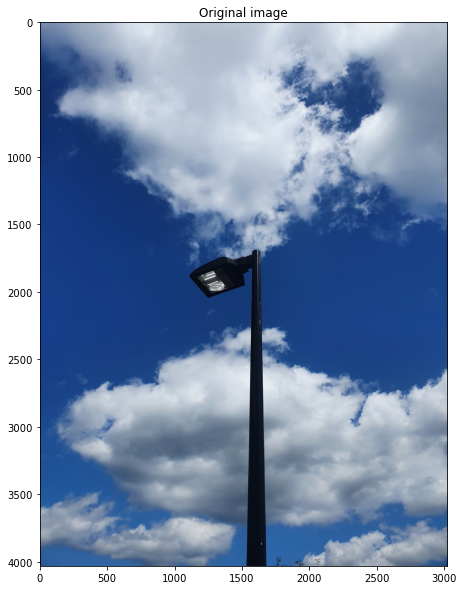

In [7]:
# Printing the original image
plt.figure(figsize = (10, 10))
plt.imshow(imgData)
plt.title("Original image")
plt.show()

In [8]:
# Timing the CPU kernel
%time h_data = convertToGrayscaleCPU(imgData)

Wall time: 2min 13s


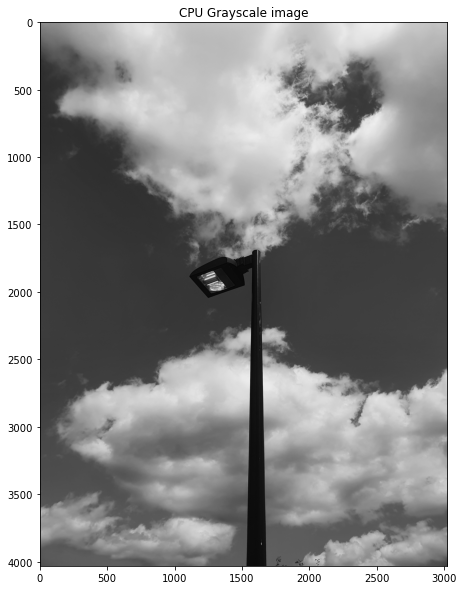

In [9]:
# Printing the grayscale image
plt.figure(figsize = (10, 10))
plt.imshow(h_data)
plt.title("CPU Grayscale image")
plt.show()

## Creating a GPU Kernel

Now, we are going to adapt the same kernel to run on the GPU

In [10]:
# Defining the GPU kernel
@cuda.jit
def convertToGrayscaleKernelV0(F):
    nx, ny = cuda.grid(2)

    if (nx < F.shape[0] and ny < F.shape[1]):
        grayVal = 0.2126 * F[nx][ny][0] + 0.7152 * F[nx][ny][1] + 0.0722 * F[nx][ny][2]
        F[nx][ny][0] = grayVal
        F[nx][ny][1] = grayVal
        F[nx][ny][2] = grayVal

In [11]:
# Reading in the data again
imgData = mpimg.imread(fileName)

In [12]:
# Copying array to the GPU
c_data = cuda.to_device(imgData)

In [13]:
# Declaring the threads and threadblocks
threadsperblock = (32, 32)
blockspergrid_x = math.ceil(imgData.shape[0] / threadsperblock[0])
blockspergrid_y = math.ceil(imgData.shape[1] / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)

In [14]:
# Timing the GPU kernel
%time convertToGrayscaleKernelV0[blockspergrid, threadsperblock](c_data)

Wall time: 491 ms


In [15]:
# Copying the data back
h_data = c_data.copy_to_host()

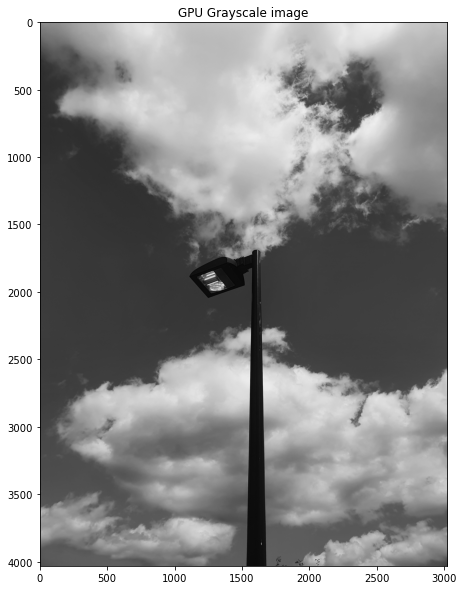

In [16]:
# Printing out the grayscale GPU image
plt.figure(figsize = (10, 10))
plt.imshow(h_data)
plt.title("GPU Grayscale image")
plt.show()

## Creating an Image Blurring Kernel

We can use a similar logic to create a kernel to blur the image by taking the average of the neighboring pixels to produce a smooth blur

In [17]:
# Creating the kernel to blur the image
@cuda.jit
def imageBlurKernelV0(N, M, F_old, F_new):
    nx, ny = cuda.grid(2)
    blur = 31

    if (nx >= 0 and ny >= 0 and nx < N-blur and ny < M-blur):

        red, green, blue = 0, 0, 0

        for i in range(blur):
            for j in range(blur):
                red += F_old[nx + i][ny + j][0]
                green += F_old[nx + i][ny + j][1]
                blue += F_old[nx + i][ny + j][2]

        F_new[nx + 15][ny + 15][0] = red/(blur * blur)
        F_new[nx + 15][ny + 15][1] = green/(blur * blur)
        F_new[nx + 15][ny + 15][2] = blue/(blur * blur)

In [18]:
# Reading in the image
imgData = mpimg.imread(fileName)
imgData.shape

(4032, 3024, 3)

In [19]:
# Adding padding to prevent errors
x = np.zeros((15, imgData.shape[1], imgData.shape[2]))
y = np.zeros((imgData.shape[0] + 30, 15, imgData.shape[2]))

imgData = np.vstack([x, imgData, x])
imgData = np.hstack([y, imgData, y])

In [20]:
# Checking if the dimensions are what we expected
imgData.shape

(4062, 3054, 3)

In [21]:
# Defining the launch conditions for the kernel
threadsperblock = (32, 32)
blockspergrid_x = math.ceil(imgData.shape[0] / threadsperblock[0])
blockspergrid_y = math.ceil(imgData.shape[1] / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)

In [22]:
# Declaring the kernel parameters
N = imgData.shape[0]
M = imgData.shape[1]

# Copying the data to the device arrays
c_oldData = cuda.to_device(imgData)
c_newData = cuda.to_device(imgData)

In [23]:
# Timing the image blurring kernel
%time imageBlurKernelV0[blockspergrid, threadsperblock](N, M, c_oldData, c_newData)

Wall time: 489 ms


In [24]:
# Copying the data back
imgData = c_newData.copy_to_host()

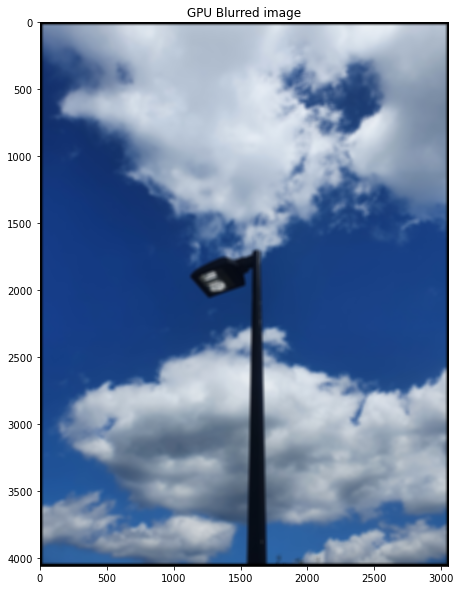

In [25]:
# Printing out the blurred image
plt.figure(figsize = (10, 10))
plt.imshow(imgData)
plt.title("GPU Blurred image")
plt.show()

## Creating a Shared Memory GPU Kernel

In [26]:
# Creating the shared memory kernel to blur the image
@cuda.jit
def imageBlurKernelV1(N, M, F_old, F_new):
    
    blur = 15
    
    tx = cuda.threadIdx.x   # x-coordinate in thread block
    ty = cuda.threadIdx.y   # y-coordinate in thread block

    dx = cuda.blockDim.x    # x-dimension of thread-block
    dy = cuda.blockDim.y    # y-dimension of thread-block

    # Thread position in entire grid
    nx, ny = cuda.grid(2)

    # Shifting the threads by buffer
    nx += blur
    ny += blur

    # Creating the shared memory tile
    tile = cuda.shared.array((32 + 30, 32 + 30 + 3, 3), numba_types.float32)

    # Checking if the thread is within our frame
    if (nx < N - blur and ny < M - blur):

        # Grabbing the values of the thread in the shared memory
        tile[tx + blur][ty + blur][0] = F_old[nx][ny][0]
        tile[tx + blur][ty + blur][1] = F_old[nx][ny][1]
        tile[tx + blur][ty + blur][2] = F_old[nx][ny][2]
        
        # Thread (0, 0) grabbing the surrounding values
        if (tx == 0 and ty == 0):

            y = 0
            for j in range(-blur, dx + blur):

                # Left Columns
                x = 0
                for i in range(-blur, 0):
                    tile[x][y][0] = F_old[nx+i][ny+j][0]
                    tile[x][y][1] = F_old[nx+i][ny+j][1]
                    tile[x][y][2] = F_old[nx+i][ny+j][2]

                    x += 1

                # Right Columns
                x = blur + dx
                for i in range(dx, dx + blur):
                    tile[x][y][0] = F_old[nx+i][ny+j][0]
                    tile[x][y][1] = F_old[nx+i][ny+j][1]
                    tile[x][y][2] = F_old[nx+i][ny+j][2]

                    x += 1
                
                y += 1
            
            x = blur
            for i in range(0, dx):

                # Rest of Top Row
                y = 0
                for j in range(-blur, 0):
                    tile[x][y][0] = F_old[nx+i][ny+j][0]
                    tile[x][y][1] = F_old[nx+i][ny+j][1]
                    tile[x][y][2] = F_old[nx+i][ny+j][2]

                    y += 1

                # Rest of Bottom Row
                y = blur + dx
                for j in range(dx, dx + blur):
                    tile[x][y][0] = F_old[nx+i][ny+j][0]
                    tile[x][y][1] = F_old[nx+i][ny+j][1]
                    tile[x][y][2] = F_old[nx+i][ny+j][2]

                    y += 1
                
                x += 1
        
        # Syncing the threads
        cuda.syncthreads()
        
        # Creating local variables to track RGB values
        red, green, blue = 0, 0, 0

        # Calculating the blur grid size
        avg_size = (blur * 2 + 1) ** 2

        # Summing up the RGB values
        for i in range(blur * 2 + 1):
            for j in range(blur * 2 + 1):
                red += tile[tx + i][ty + j][0]
                green += tile[tx + i][ty + j][1]
                blue += tile[tx + i][ty + j][2]

        red = red / avg_size
        green = green / avg_size
        blue = blue / avg_size
                
        # Averaging the values and updating the new array
        F_new[nx][ny][0] = red
        F_new[nx][ny][1] = green
        F_new[nx][ny][2] = blue

In [27]:
# Reading in the image
imgData = mpimg.imread(fileName)
imgData.shape

(4032, 3024, 3)

In [28]:
# Adding padding to prevent errors
x = np.zeros((15, imgData.shape[1], imgData.shape[2]))
y = np.zeros((imgData.shape[0] + 30, 15, imgData.shape[2]))

imgData = np.vstack([x, imgData, x])
imgData = np.hstack([y, imgData, y])

In [29]:
# Checking if the dimensions are what we expected
imgData.shape

(4062, 3054, 3)

In [30]:
# Defining the launch conditions for the kernel
threadsperblock = (32, 32)
blockspergrid_x = math.ceil(imgData.shape[0] / threadsperblock[0])
blockspergrid_y = math.ceil(imgData.shape[1] / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)

In [31]:
# Declaring the kernel parameters
N = imgData.shape[0]
M = imgData.shape[1]

# Copying the data to the device arrays
c_oldData = cuda.to_device(imgData, copy = True)
c_newData = cuda.to_device(imgData, copy = True)

In [32]:
# Timing the image blurring kernel
%time imageBlurKernelV1[blockspergrid, threadsperblock](N, M, c_oldData, c_newData)

Wall time: 2.1 s


In [33]:
# Copying the data back
imgData = c_newData.copy_to_host()

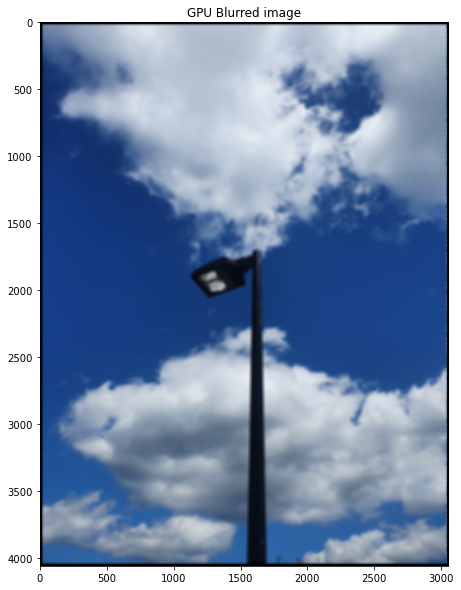

In [34]:
# Printing out the blurred image
plt.figure(figsize = (10, 10))
plt.imshow(imgData)
plt.title("GPU Blurred image")
plt.show()